Kaggle生成HTML的时候，是从上到下重新执行一遍。所以如果要输出正确的结果，需要按照从上到下的顺序。
由于使用了widget，需要手动筛选，因此顺序执行的输出结果意义也不大了。就不用麻烦了。

# download image

In [1]:
from fastai.vision import *

In [2]:
folder = 'black'
file = 'black_bear.txt'

In [3]:
folder = 'grizzly'
file = 'grizzly_bear.txt'

In [4]:
folder = 'teddy'
file = 'teddy_bear.txt'

In [5]:
# 设置所有数据存放的根目录
path = Path('/kaggle/working/data/bears')
path.mkdir(parents=True, exist_ok=True)

In [6]:
# 在kaggle中，将导入的数据，从只读目录复制到工作区可写目录下
!cp /kaggle/input/* {path}/
# 安装tree命令
!apt get tree

E: Invalid operation get


In [7]:
!tree {path}

/bin/sh: 1: tree: not found


In [8]:
# 创建各个类别图像下载的目录
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
# 下载图像
download_images(path/file, dest, max_pics=200)

In [9]:
# 创建类别
classes = ['black', 'grizzly', 'teddy']
# 删除不能被打开的错误图像
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# create data bunch

In [10]:
# 置固定的随机数种子，保证每次创建相同的验证集，以便调整超参数
np.random.seed(42)
# 默认训练集会在train目录下查找。用.设置为当前目录，并且划分验证集
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['teddy'], 1, 149, 37)

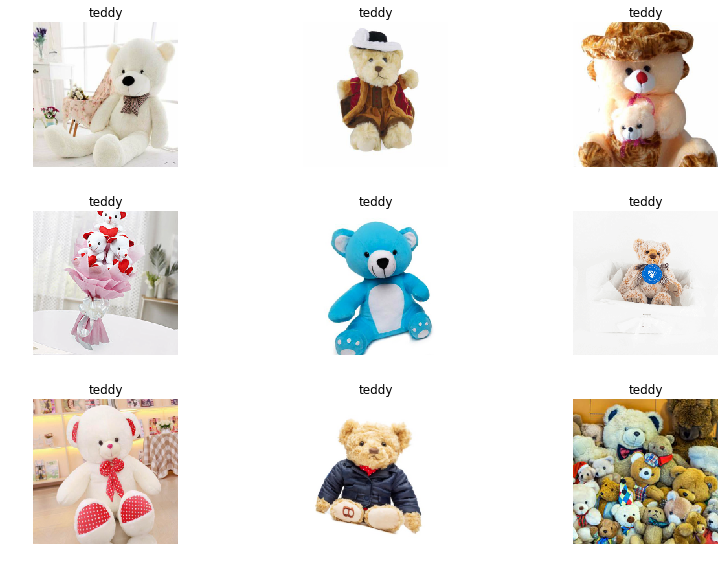

In [12]:
data.show_batch(rows=3, figsize=(12,8))

# train and interpret

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)
learn.save('stage-1')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 118295724.90it/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:04
1,0.000000,0.000000,0.000000,00:02
2,0.000000,0.000000,0.000000,00:02
3,0.000000,0.000000,0.000000,00:02


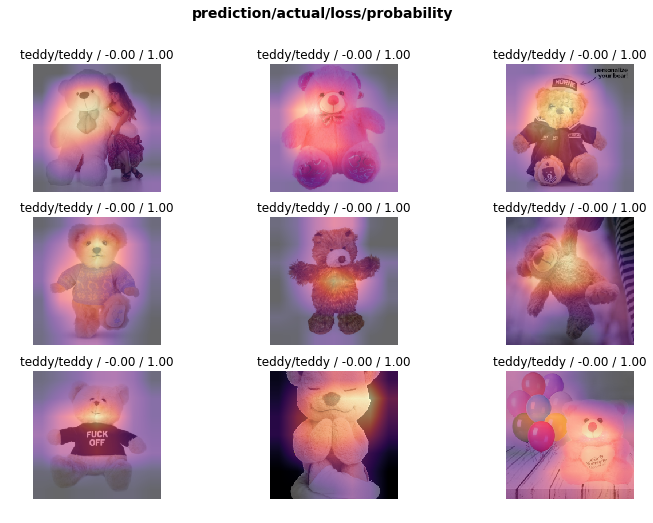

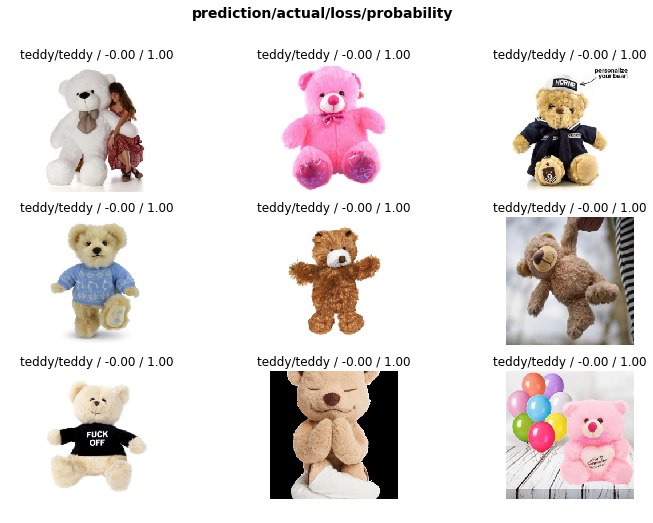

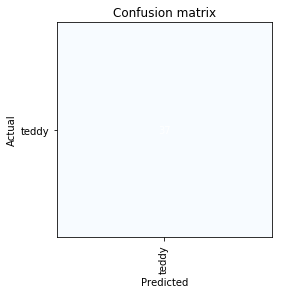

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,8))
interp.plot_top_losses(9, figsize=(12,8), heatmap=False)
interp.plot_confusion_matrix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


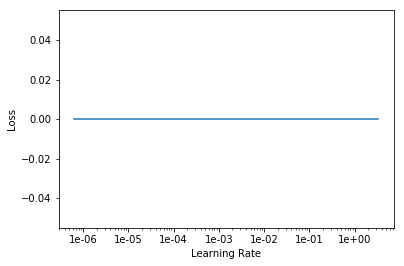

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,3e-4))
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:03
1,0.000000,0.000000,0.000000,00:02


# clean data - clean top losses

In [17]:
from fastai.widgets import *

In [18]:
# 创建一个没有划分验证集的数据集。即包含所有数据的数据集
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [19]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
len(idxs)

186

In [20]:
doc(DatasetFormatter().from_toplosses)

In [21]:
# 取前25个进行clean
idxs = idxs[:25]

In [22]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [23]:
!tree

/bin/sh: 1: tree: not found


In [24]:
# 查看cleaned.csv 里面保存的是被清理之后的正确标签
!cat {path}/cleaned.csv -n

# clean data - clean duplicate

In [25]:
# 从cleaned.csv 创建训练集
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [26]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');
ds, idxs = DatasetFormatter().from_similars(learn_cln)
len(idxs)

Getting activations...


Computing similarities...


372

In [27]:
idxs = idxs[:10]

In [28]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# retrain and reinterpret

In [29]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [30]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['teddy'], 1, 149, 37)

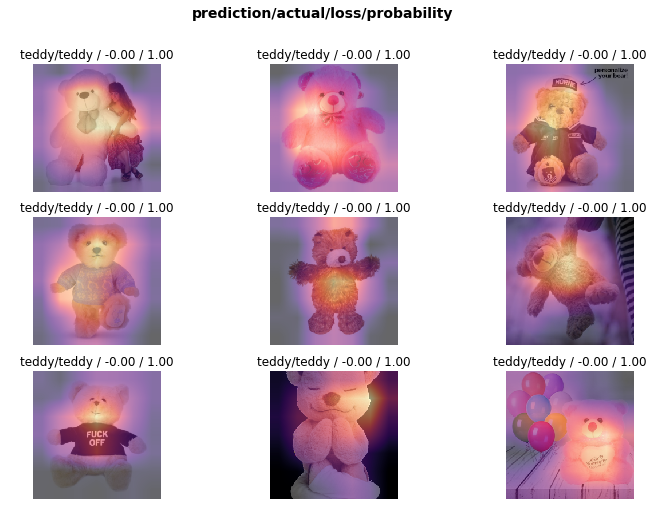

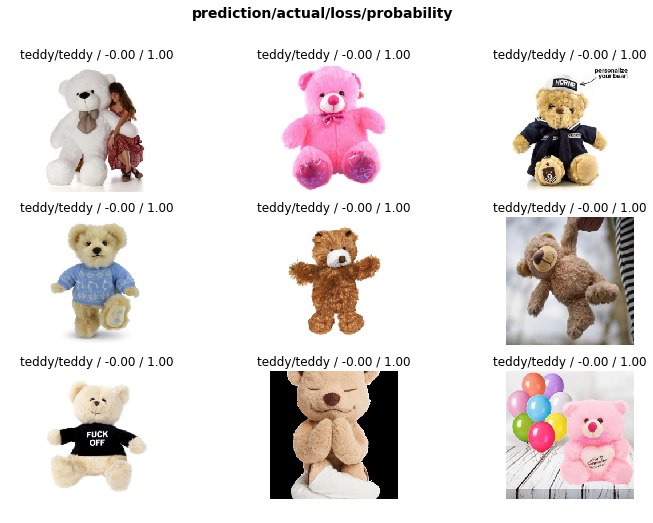

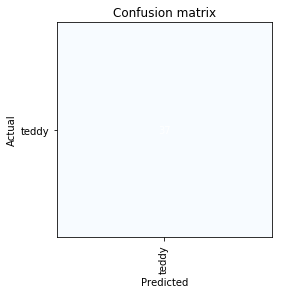

In [31]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.load('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,8))
interp.plot_top_losses(9, figsize=(12,8),heatmap=False)
interp.plot_confusion_matrix()

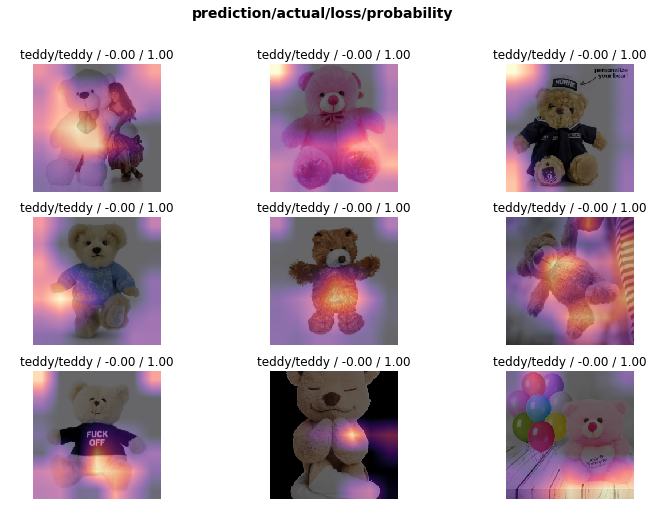

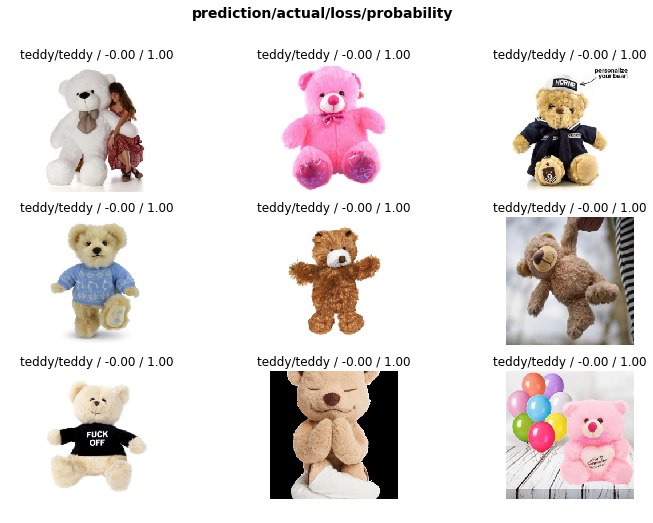

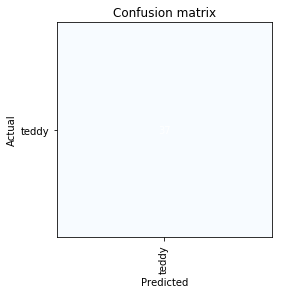

In [32]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,8))
interp.plot_top_losses(9, figsize=(12,8),heatmap=False)
interp.plot_confusion_matrix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


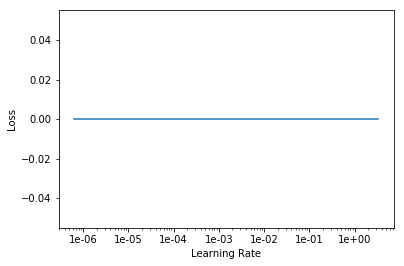

In [33]:
learn.lr_find()
learn.recorder.plot()

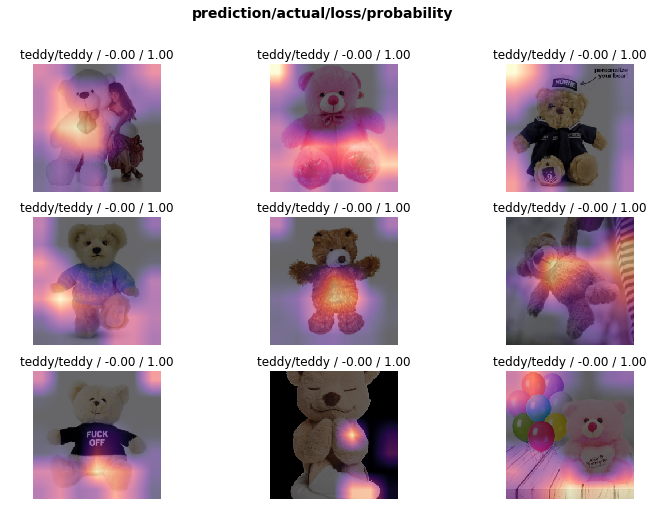

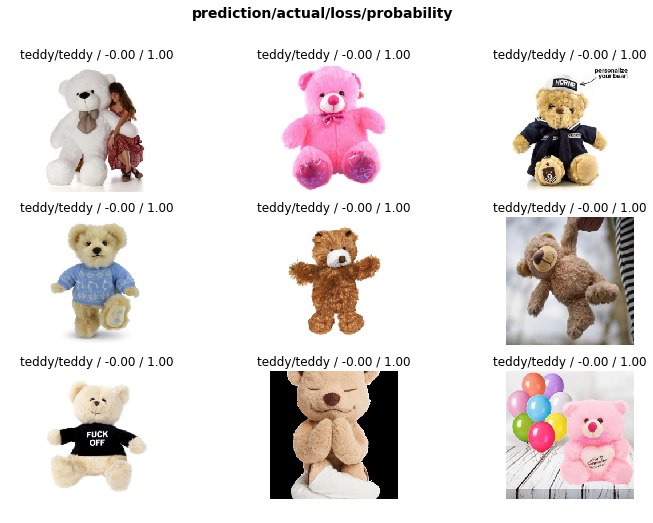

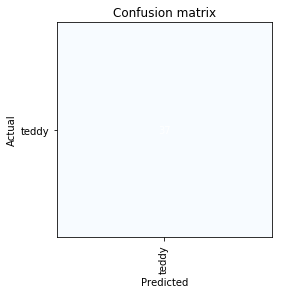

In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,3e-4))
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,8))
interp.plot_top_losses(9, figsize=(12,8),heatmap=False)
interp.plot_confusion_matrix()